In [1]:
import pandas as pd
from datetime import datetime
from azure.identity import DefaultAzureCredential
from azure.monitor.query import LogsQueryClient, MetricsQueryClient
import json
import numpy as np
import matplotlib.pyplot as plt
from azure.core.exceptions import HttpResponseError

In [2]:
# Load results from benchmark controller
df_bench = pd.read_csv('benchmark_results.csv')

In [3]:
df_bench.groupby(['random_seed','initial_patients','initial_beds'],).mean()

simulation_time    num_beds  \
random_seed initial_patients initial_beds                                
9           8                219                     182.0  379.479452   
10          27               295                     182.0  422.315068   
            67               264                     182.0  472.356164   
11          66               248                     182.0  464.479452   
13          93               285                     182.0  497.506849   
14          82               289                     182.0  471.260274   
17          78               243                     182.0  464.369863   
18          74               286                     182.0  465.136986   
            86               262                     182.0  484.589041   
22          51               244                     182.0  441.123288   
25          96               233                     182.0  499.917808   
27          49               209                     182.0  432.287671   
28          11               208                     182.0  387.356164   
            95               202                     182.0  496.986301   
32          90               226                     182.0  485.438356   
34          2                293                     182.0  383.917808   
38          15               297                     182.0  389.013699   
40          42               263                     182.0  428.739726   
            50               297                     182.0  441.534247   
            81               221                     182.0  476.821918   
48          30               291                     182.0  413.904110   
            73               233                     182.0  468.410959   
56          69               230                     182.0  459.931507   
60          40               278                     182.0  425.739726   
61          30               285                     182.0  425.150685   
63          62               289                     182.0  451.342466   
            68               257                     182.0  460.123288   
66          47               235                     182.0  438.027397   
68          86               215                     182.0  486.273973   
71          48               211                     182.0  436.164384   
72          100              251                     182.0  500.205479   
76          4                206                     182.0  384.575342   
            53               293                     182.0  447.232877   
79          90               220                     182.0  493.205479   
80          71               264                     182.0  465.410959   
81          90               291                     182.0  496.589041   
90          100              295                     182.0  496.863014   
92          54               256                     182.0  439.958904   
96          2                228                     182.0  379.753425   
99          95               225                     182.0  491.041096   

                                           num_patients  \
random_seed initial_patients initial_beds                 
9           8                219             300.021918   
10          27               295             326.860274   
            67               264             366.441096   
11          66               248             362.095890   
13          93               285             389.649315   
14          82               289             375.709589   
17          78               243             370.517808   
18          74               286             369.613699   
            86               262             380.019178   
22          51               244             347.372603   
25          96               233             394.024658   
27          49               209             340.975342   
28          11               208             306.638356   
            95               202             391.

In [ ]:
# Azure login credentials
credential = DefaultAzureCredential()
client = LogsQueryClient(credential)

In [ ]:
# Define query for brain assessment results
query = """
        let _brain_name = "hospital";
        let _brain_version = 16;
        let _assessment_name = "bonsai_assessment_40";
        EpisodeLog_CL
        | where BrainName_s == _brain_name and BrainVersion_d == _brain_version and AssessmentName_s == _assessment_name
        | join kind=inner (
            IterationLog_CL
            | sort by Timestamp_t desc
        ) on EpisodeId_g
        | project
            AssessmentName = AssessmentName_s,
            EpisodeId = EpisodeId_g,
            IterationIndex = IterationIndex_d,
            Timestamp = Timestamp_t,
            SimConfig = parse_json(SimConfig_s),
            SimState = parse_json(SimState_s),
            SimAction = parse_json(SimAction_s),
            Reward = Reward_d,
            CumulativeReward = CumulativeReward_d,
            GoalMetrics = parse_json(GoalMetrics_s),
            Terminal = Terminal_b,
            FinishReason = FinishReason_s,
            LessonIndex = LessonIndex_d,
            EpisodeType = EpisodeType_s
        | order by EpisodeId asc, IterationIndex asc
        """

In [ ]:
# returns LogsQueryResult
response = client.query_workspace(
   workspace_id="e1403c4c-eedd-4b20-92dd-70f49b3b5eb1",
   query=query,
   timespan=None
   )

In [ ]:
# convert to Pandas dataframe
for table in response.tables:
    df = pd.DataFrame(table.rows, columns=[col for col in table.columns])

In [ ]:
# Expand nested dictionaries
jsonloads = lambda x: json.loads('{}') if not x  else json.loads(x)
df = pd.concat([
    df[['EpisodeId','IterationIndex','Reward']],
    pd.json_normalize(df['SimConfig'].apply(jsonloads)),
    pd.json_normalize(df['SimState'].apply(jsonloads)),
    pd.json_normalize(df['SimAction'].apply(jsonloads)),
], axis=1)

In [ ]:
df.head()

In [4]:
def plot_results(df):
    _, (ax0, ax1, ax2) = plt.subplots(
    nrows=3, ncols=1, sharex=True, figsize=(12, 6), dpi=160
    )

    # plot the number of patients and beds over time
    ax0.scatter(df['simulation_time'], df['num_beds'], s=16, label="# of beds")
    ax0.scatter(df['simulation_time'], df['num_patients'], s=16, label="# of patients")
    ax0.scatter(df['simulation_time'], df['num_patients_overflow'], s=16, label="# of overflow patients")
    ax0.legend(loc=(0.7718, 0.12))
    ax0.grid(linewidth=0.2)

        # color utilization by whether it falls in the target range
    colors = ["C2" if 0.7 <= point <= 0.9 else "C3" for point in df['utilization']]

    # plot utilization over time
    ax1.scatter(
        df['simulation_time'], df['utilization'], s=16, c=colors, label="utilization (actual)"
    )

    # plot target utilization range
    N = 100
    ax1.fill_between(
        x=np.linspace(0, 2*365, N),
        y1=0.7 * np.ones(N),
        y2=0.9 * np.ones(N),
        color="gray",
        alpha=0.25,
        label="utilization (target)",
    )

    ax1.set_xlabel("Simulation Time (days)")
    ax1.legend(loc="lower right")
    ax1.grid(linewidth=0.2)

    ax2.scatter(df['simulation_time'], df['change_beds'], s=16, c=colors, label="\delta# in beds")

    plt.show()

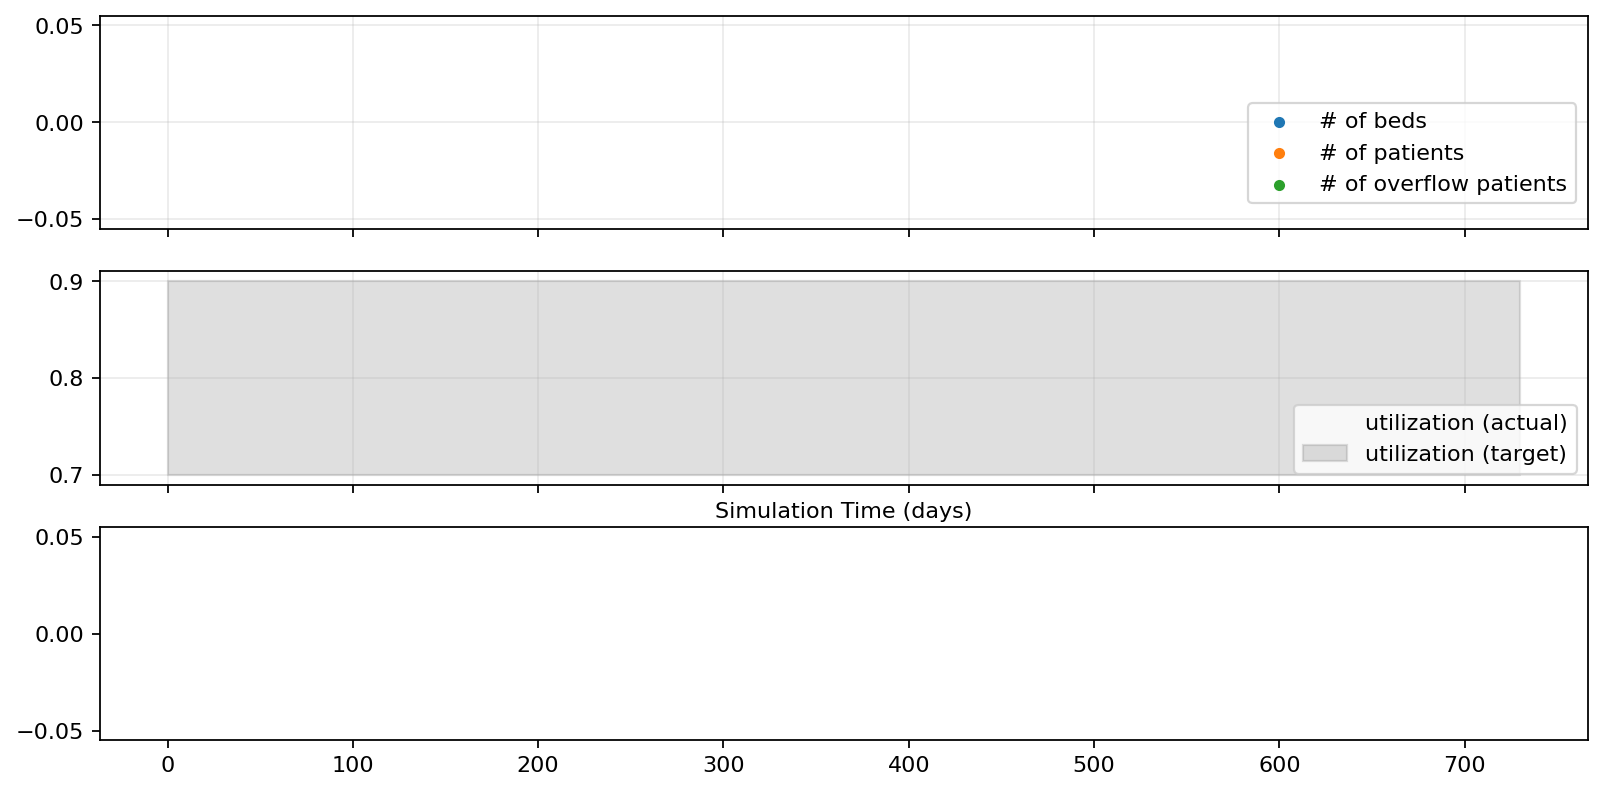

In [5]:
plot_results(df_bench[df_bench['random_seed']==2])

In [ ]:
plot_results(df[df['random_seed']==2])

In [ ]:
def kpi_report(df):
    return{
        "Average Utilization": df['utilization'].mean(),
        "Std Utilization": df['utilization'].std(),
        "% Above Target Utilization": 100*sum(df['utilization']>.9)/df.shape[0],
        "% Below Target Utilization": 100*sum(df['utilization']<.7)/df.shape[0],
        "# iterations with |change_beds|>0": sum(df['change_beds'].abs()>0)
    }

In [ ]:
kpi_report(df_bench)

In [ ]:
kpi_report(df)